<a href="https://colab.research.google.com/github/stavco9/datastreaming-final-project/blob/main/Data_Analysis_DeezyMatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install DeezyMatch
!pip install thefuzz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 107.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 

In [16]:
import os
import tqdm
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DeezyMatch import candidate_ranker, candidate_ranker_init
from thefuzz import process, fuzz

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/IDC_MSc/Year1/DataStreamingAlgorithms/DeezyMatchDataset"

Mounted at /content/drive
/content/drive/My Drive/IDC_MSc/Year1/DataStreamingAlgorithms/DeezyMatchDataset


In [4]:
words_set = []
for i in range(10):
  candidates_file = f"./candidates/dataset_candidates_{i}.txt"
  with open(candidates_file, 'r') as f:
    words_list = f.read().split('\n')
    words_set.append({"words_list": words_list})

In [5]:
some_sentance_with_error = "I wanna appel pleases or a bannana with a paer and a lemone, \
or a wartermelon if possibe. I hope i don't have an \
errof in Londaon and in Jerusealm"

In [6]:
def format_word(word):
  if len(word) > 1:
    last_char = word[-1]
    while not last_char.isalpha():
      word = word[:-1]
      last_char = word[-1]

    first_char = word[0]
    while not first_char.isalpha():
      word = word[1:]
      first_char = word[0]

    word = word.lower()

  return word

In [7]:
for index, words_list in enumerate(words_set):
    time_start_naive = time.time()
    words_set[index]["naive_matches"] = {}
    words_set[index]["naive_matches"]["origin_words"] = []
    words_set[index]["naive_matches"]["matched_words"] = []
    words_set[index]["naive_matches"]["match_scores"] = []
    for word in some_sentance_with_error.split():
      words_set[index]["naive_matches"]["origin_words"].append(format_word(word))
      word_match_results = [x for x in process.extract(word, words_list["words_list"], scorer=fuzz.ratio)]
      words_set[index]["naive_matches"]["matched_words"].append(format_word(word_match_results[0][0]) if len(word_match_results) > 0 else "None")
      words_set[index]["naive_matches"]["match_scores"].append(int(word_match_results[0][1]) / 100 if len(word_match_results) > 0 else 0)
    time_end_naive = time.time()
    words_set[index]["time_naive_sec"] = (time_end_naive - time_start_naive)

In [9]:
for index in range(10):
  # Ranking on-the-fly
  # find candidates from candidate_scenario
  # for queries specified by the `query` argument
  time_start_deezy = time.time()
  ranker = \
      candidate_ranker_init(candidate_scenario=f"./combined/candidates_test_{index}",
                      query=[x.replace("-", " ") for x in some_sentance_with_error.split()],
                      ranking_metric="faiss",
                      selection_threshold=10.,
                      num_candidates=1,
                      search_size=100,
                      output_path=f"ranker_results/test_candidates_deezymatch_on_the_fly_{index}",
                      pretrained_model_path="./models/wikigaz_en_model/wikigaz_en_model.model",
                      pretrained_vocab_path="./models/wikigaz_en_model/wikigaz_en_model.vocab",
                      number_test_rows=len(some_sentance_with_error))

  ranker.rank()
  words_set[index]["deezy_match_df"] = ranker.output
  time_end_deezy = time.time()
  words_set[index]["time_deezy_sec"] = (time_end_deezy - time_start_deezy)

2024-03-26 21:15:32 a2a12c08299c [INFO] read input file: ./combined/candidates_test_0/train_conf.yaml
2024-03-26 21:15:32 a2a12c08299c [INFO] pytorch will use: cuda
2024-03-26 21:15:33 a2a12c08299c [INFO] use a dataframe in test_tokenize.
2024-03-26 21:15:33 a2a12c08299c [INFO] number of labels, True: 0 and False: 30
2024-03-26 21:15:33 a2a12c08299c [INFO] skipping 0 lines


2024-03-26 21:15:33 a2a12c08299c [INFO] save test-data-class: tmp_2352c04c-c1dd-46f6-b698-ee3c633c7715/query/dataframe.df


  0%|          | 0/1 [00:00<?, ?it/s]



-- Combine vectors
Reading vectors from tmp_2352c04c-c1dd-46f6-b698-ee3c633c7715/query/embeddings/rnn_fwd*
0000000 tmp_2352c04c-c1dd-46f6-b698-ee3c633c7715/query/embeddings/rnn_fwd_0


-- Combine IDs

0000000 tmp_2352c04c-c1dd-46f6-b698-ee3c633c7715/query/embeddings/rnn_indxs_0


-- Combine vectors
Reading vectors from tmp_2352c04c-c1dd-46f6-b698-ee3c633c7715/query/embeddings/rnn_bwd*
0000000 tmp_2352c04c-c1dd-46f6-b698-ee3c633c7715/query/embeddings/rnn_bwd_0


-- Combine IDs

0000000 tmp_2352c04c-c1dd-46f6-b698-ee3c633c7715/query/embeddings/rnn_indxs_0
--- 294.7297155857086 seconds ---
Is faiss_id_candis already trained? True
=========== Start the search for 0 I
ID: 1/30 -- Number of found candidates so far: 3, searched: 100
=========== Start the search for 1 wanna
ID: 2/30 -- Number of found candidates so far: 5, searched: 100
=========== Start the search for 2 appel
ID: 3/30 -- Number of found candidates so far: 30, searched: 100
=========== Start the search for 3 pleases
ID: 4/30

2024-03-26 21:15:35 a2a12c08299c [INFO] save test-data-class: tmp_25fd4386-835f-429e-ba9c-74e61eb920bd/query/dataframe.df


  0%|          | 0/1 [00:00<?, ?it/s]



-- Combine vectors
Reading vectors from tmp_25fd4386-835f-429e-ba9c-74e61eb920bd/query/embeddings/rnn_fwd*
0000000 tmp_25fd4386-835f-429e-ba9c-74e61eb920bd/query/embeddings/rnn_fwd_0


-- Combine IDs

0000000 tmp_25fd4386-835f-429e-ba9c-74e61eb920bd/query/embeddings/rnn_indxs_0


-- Combine vectors
Reading vectors from tmp_25fd4386-835f-429e-ba9c-74e61eb920bd/query/embeddings/rnn_bwd*
0000000 tmp_25fd4386-835f-429e-ba9c-74e61eb920bd/query/embeddings/rnn_bwd_0


-- Combine IDs

0000000 tmp_25fd4386-835f-429e-ba9c-74e61eb920bd/query/embeddings/rnn_indxs_0
--- 297.1995334625244 seconds ---
Is faiss_id_candis already trained? True
=========== Start the search for 0 I
ID: 1/30 -- Number of found candidates so far: 2, searched: 100
=========== Start the search for 1 wanna
ID: 2/30 -- Number of found candidates so far: 6, searched: 100
=========== Start the search for 2 appel
ID: 3/30 -- Number of found candidates so far: 34, searched: 100
=========== Start the search for 3 pleases
ID: 4/30

2024-03-26 21:15:37 a2a12c08299c [INFO] save test-data-class: tmp_450ab24c-d527-4268-aa1c-e53ee3d3c286/query/dataframe.df


  0%|          | 0/1 [00:00<?, ?it/s]



-- Combine vectors
Reading vectors from tmp_450ab24c-d527-4268-aa1c-e53ee3d3c286/query/embeddings/rnn_fwd*
0000000 tmp_450ab24c-d527-4268-aa1c-e53ee3d3c286/query/embeddings/rnn_fwd_0


-- Combine IDs

0000000 tmp_450ab24c-d527-4268-aa1c-e53ee3d3c286/query/embeddings/rnn_indxs_0


-- Combine vectors
Reading vectors from tmp_450ab24c-d527-4268-aa1c-e53ee3d3c286/query/embeddings/rnn_bwd*
0000000 tmp_450ab24c-d527-4268-aa1c-e53ee3d3c286/query/embeddings/rnn_bwd_0


-- Combine IDs

0000000 tmp_450ab24c-d527-4268-aa1c-e53ee3d3c286/query/embeddings/rnn_indxs_0
--- 299.11575412750244 seconds ---
Is faiss_id_candis already trained? True
=========== Start the search for 0 I
ID: 1/30 -- Number of found candidates so far: 3, searched: 100
=========== Start the search for 1 wanna
ID: 2/30 -- Number of found candidates so far: 3, searched: 100
=========== Start the search for 2 appel
ID: 3/30 -- Number of found candidates so far: 22, searched: 100
=========== Start the search for 3 pleases
ID: 4/3

2024-03-26 21:15:39 a2a12c08299c [INFO] save test-data-class: tmp_38415e1a-559d-4e89-a88a-c3609e8201db/query/dataframe.df


  0%|          | 0/1 [00:00<?, ?it/s]



-- Combine vectors
Reading vectors from tmp_38415e1a-559d-4e89-a88a-c3609e8201db/query/embeddings/rnn_fwd*
0000000 tmp_38415e1a-559d-4e89-a88a-c3609e8201db/query/embeddings/rnn_fwd_0


-- Combine IDs

0000000 tmp_38415e1a-559d-4e89-a88a-c3609e8201db/query/embeddings/rnn_indxs_0


-- Combine vectors
Reading vectors from tmp_38415e1a-559d-4e89-a88a-c3609e8201db/query/embeddings/rnn_bwd*
0000000 tmp_38415e1a-559d-4e89-a88a-c3609e8201db/query/embeddings/rnn_bwd_0


-- Combine IDs

0000000 tmp_38415e1a-559d-4e89-a88a-c3609e8201db/query/embeddings/rnn_indxs_0
--- 300.92459511756897 seconds ---
Is faiss_id_candis already trained? True
=========== Start the search for 0 I
ID: 1/30 -- Number of found candidates so far: 3, searched: 100
=========== Start the search for 1 wanna
ID: 2/30 -- Number of found candidates so far: 8, searched: 100
=========== Start the search for 2 appel
ID: 3/30 -- Number of found candidates so far: 37, searched: 100
=========== Start the search for 3 pleases
ID: 4/3

2024-03-26 21:15:41 a2a12c08299c [INFO] save test-data-class: tmp_2e15c1ed-2b0b-4948-af82-a3cedb210e84/query/dataframe.df


  0%|          | 0/1 [00:00<?, ?it/s]



-- Combine vectors
Reading vectors from tmp_2e15c1ed-2b0b-4948-af82-a3cedb210e84/query/embeddings/rnn_fwd*
0000000 tmp_2e15c1ed-2b0b-4948-af82-a3cedb210e84/query/embeddings/rnn_fwd_0


-- Combine IDs

0000000 tmp_2e15c1ed-2b0b-4948-af82-a3cedb210e84/query/embeddings/rnn_indxs_0


-- Combine vectors
Reading vectors from tmp_2e15c1ed-2b0b-4948-af82-a3cedb210e84/query/embeddings/rnn_bwd*
0000000 tmp_2e15c1ed-2b0b-4948-af82-a3cedb210e84/query/embeddings/rnn_bwd_0


-- Combine IDs

0000000 tmp_2e15c1ed-2b0b-4948-af82-a3cedb210e84/query/embeddings/rnn_indxs_0
--- 302.87231516838074 seconds ---
Is faiss_id_candis already trained? True
=========== Start the search for 0 I
ID: 1/30 -- Number of found candidates so far: 2, searched: 100
=========== Start the search for 1 wanna
ID: 2/30 -- Number of found candidates so far: 2, searched: 100
=========== Start the search for 2 appel
ID: 3/30 -- Number of found candidates so far: 31, searched: 100
=========== Start the search for 3 pleases
ID: 4/3

2024-03-26 21:15:43 a2a12c08299c [INFO] save test-data-class: tmp_46dfe65c-6578-4e75-af16-ea7e95db874a/query/dataframe.df


  0%|          | 0/1 [00:00<?, ?it/s]



-- Combine vectors
Reading vectors from tmp_46dfe65c-6578-4e75-af16-ea7e95db874a/query/embeddings/rnn_fwd*
0000000 tmp_46dfe65c-6578-4e75-af16-ea7e95db874a/query/embeddings/rnn_fwd_0


-- Combine IDs

0000000 tmp_46dfe65c-6578-4e75-af16-ea7e95db874a/query/embeddings/rnn_indxs_0


-- Combine vectors
Reading vectors from tmp_46dfe65c-6578-4e75-af16-ea7e95db874a/query/embeddings/rnn_bwd*
0000000 tmp_46dfe65c-6578-4e75-af16-ea7e95db874a/query/embeddings/rnn_bwd_0


-- Combine IDs

0000000 tmp_46dfe65c-6578-4e75-af16-ea7e95db874a/query/embeddings/rnn_indxs_0
--- 304.65258145332336 seconds ---
Is faiss_id_candis already trained? True
=========== Start the search for 0 I
ID: 1/30 -- Number of found candidates so far: 3, searched: 100
=========== Start the search for 1 wanna
ID: 2/30 -- Number of found candidates so far: 5, searched: 100
=========== Start the search for 2 appel
ID: 3/30 -- Number of found candidates so far: 24, searched: 100
=========== Start the search for 3 pleases
ID: 4/3

2024-03-26 21:15:44 a2a12c08299c [INFO] save test-data-class: tmp_05abe327-59fa-4806-8540-c5c434318824/query/dataframe.df


  0%|          | 0/1 [00:00<?, ?it/s]



-- Combine vectors
Reading vectors from tmp_05abe327-59fa-4806-8540-c5c434318824/query/embeddings/rnn_fwd*
0000000 tmp_05abe327-59fa-4806-8540-c5c434318824/query/embeddings/rnn_fwd_0


-- Combine IDs

0000000 tmp_05abe327-59fa-4806-8540-c5c434318824/query/embeddings/rnn_indxs_0


-- Combine vectors
Reading vectors from tmp_05abe327-59fa-4806-8540-c5c434318824/query/embeddings/rnn_bwd*
0000000 tmp_05abe327-59fa-4806-8540-c5c434318824/query/embeddings/rnn_bwd_0


-- Combine IDs

0000000 tmp_05abe327-59fa-4806-8540-c5c434318824/query/embeddings/rnn_indxs_0
--- 306.46432280540466 seconds ---
Is faiss_id_candis already trained? True
=========== Start the search for 0 I
ID: 1/30 -- Number of found candidates so far: 3, searched: 100
=========== Start the search for 1 wanna
ID: 2/30 -- Number of found candidates so far: 4, searched: 100
=========== Start the search for 2 appel
ID: 3/30 -- Number of found candidates so far: 14, searched: 100
=========== Start the search for 3 pleases
ID: 4/3

2024-03-26 21:15:46 a2a12c08299c [INFO] save test-data-class: tmp_110f65ba-4696-4a6a-959d-5a9950e89c6e/query/dataframe.df


  0%|          | 0/1 [00:00<?, ?it/s]



-- Combine vectors
Reading vectors from tmp_110f65ba-4696-4a6a-959d-5a9950e89c6e/query/embeddings/rnn_fwd*
0000000 tmp_110f65ba-4696-4a6a-959d-5a9950e89c6e/query/embeddings/rnn_fwd_0


-- Combine IDs

0000000 tmp_110f65ba-4696-4a6a-959d-5a9950e89c6e/query/embeddings/rnn_indxs_0


-- Combine vectors
Reading vectors from tmp_110f65ba-4696-4a6a-959d-5a9950e89c6e/query/embeddings/rnn_bwd*
0000000 tmp_110f65ba-4696-4a6a-959d-5a9950e89c6e/query/embeddings/rnn_bwd_0


-- Combine IDs

0000000 tmp_110f65ba-4696-4a6a-959d-5a9950e89c6e/query/embeddings/rnn_indxs_0
--- 308.5854022502899 seconds ---
Is faiss_id_candis already trained? True
=========== Start the search for 0 I
ID: 1/30 -- Number of found candidates so far: 3, searched: 100
=========== Start the search for 1 wanna
ID: 2/30 -- Number of found candidates so far: 4, searched: 100
=========== Start the search for 2 appel
ID: 3/30 -- Number of found candidates so far: 31, searched: 100
=========== Start the search for 3 pleases
ID: 4/30

2024-03-26 21:15:49 a2a12c08299c [INFO] save test-data-class: tmp_06e43a5a-6e3d-406d-bf92-b8846f027f73/query/dataframe.df


  0%|          | 0/1 [00:00<?, ?it/s]



-- Combine vectors
Reading vectors from tmp_06e43a5a-6e3d-406d-bf92-b8846f027f73/query/embeddings/rnn_fwd*
0000000 tmp_06e43a5a-6e3d-406d-bf92-b8846f027f73/query/embeddings/rnn_fwd_0


-- Combine IDs

0000000 tmp_06e43a5a-6e3d-406d-bf92-b8846f027f73/query/embeddings/rnn_indxs_0


-- Combine vectors
Reading vectors from tmp_06e43a5a-6e3d-406d-bf92-b8846f027f73/query/embeddings/rnn_bwd*
0000000 tmp_06e43a5a-6e3d-406d-bf92-b8846f027f73/query/embeddings/rnn_bwd_0


-- Combine IDs

0000000 tmp_06e43a5a-6e3d-406d-bf92-b8846f027f73/query/embeddings/rnn_indxs_0
--- 311.01942110061646 seconds ---
Is faiss_id_candis already trained? True
=========== Start the search for 0 I
ID: 1/30 -- Number of found candidates so far: 3, searched: 100
=========== Start the search for 1 wanna
ID: 2/30 -- Number of found candidates so far: 4, searched: 100
=========== Start the search for 2 appel
ID: 3/30 -- Number of found candidates so far: 29, searched: 100
=========== Start the search for 3 pleases
ID: 4/3

2024-03-26 21:15:51 a2a12c08299c [INFO] save test-data-class: tmp_616cbe89-9b1a-4113-8369-3775c05bb1bc/query/dataframe.df


  0%|          | 0/1 [00:00<?, ?it/s]



-- Combine vectors
Reading vectors from tmp_616cbe89-9b1a-4113-8369-3775c05bb1bc/query/embeddings/rnn_fwd*
0000000 tmp_616cbe89-9b1a-4113-8369-3775c05bb1bc/query/embeddings/rnn_fwd_0


-- Combine IDs

0000000 tmp_616cbe89-9b1a-4113-8369-3775c05bb1bc/query/embeddings/rnn_indxs_0


-- Combine vectors
Reading vectors from tmp_616cbe89-9b1a-4113-8369-3775c05bb1bc/query/embeddings/rnn_bwd*
0000000 tmp_616cbe89-9b1a-4113-8369-3775c05bb1bc/query/embeddings/rnn_bwd_0


-- Combine IDs

0000000 tmp_616cbe89-9b1a-4113-8369-3775c05bb1bc/query/embeddings/rnn_indxs_0
--- 312.87891125679016 seconds ---
Is faiss_id_candis already trained? True
=========== Start the search for 0 I
ID: 1/30 -- Number of found candidates so far: 2, searched: 100
=========== Start the search for 1 wanna
ID: 2/30 -- Number of found candidates so far: 3, searched: 100
=========== Start the search for 2 appel
ID: 3/30 -- Number of found candidates so far: 33, searched: 100
=========== Start the search for 3 pleases
ID: 4/3

In [10]:
for index in range(10):
    deezy_match_df = words_set[index]["deezy_match_df"]
    words_set[index]["deezy_matches"] = {}
    words_set[index]["deezy_matches"]["origin_words"] = []
    words_set[index]["deezy_matches"]["matched_words"] = []
    words_set[index]["deezy_matches"]["match_distance"] = []
    for word in some_sentance_with_error.split():
      word_df_row = deezy_match_df.loc[deezy_match_df['query'] == word].iloc[0]
      words_set[index]["deezy_matches"]["origin_words"].append(format_word(word))
      words_set[index]["deezy_matches"]["matched_words"].append(format_word(list(word_df_row['faiss_distance'].keys())[0]) if bool(word_df_row['faiss_distance']) else None)
      words_set[index]["deezy_matches"]["match_distance"].append(list(word_df_row['faiss_distance'].values())[0] if bool(word_df_row['faiss_distance']) else -1)

In [11]:
for index, words_list in enumerate(words_set):
   print(f"Total time of dataset {index + 1} is {words_list['time_naive_sec']}s")
   print(f"Origin words for dataset {index + 1} are {words_list['naive_matches']['origin_words']}")
   print(f"Matches words for dataset {index + 1} are {words_list['naive_matches']['matched_words']}")
   print(f"Matches scores for dataset {index + 1} are {words_list['naive_matches']['match_scores']}")

Total time of dataset 1 is 3.9284653663635254s
Origin words for dataset 1 are ['I', 'wanna', 'appel', 'pleases', 'or', 'a', 'bannana', 'with', 'a', 'paer', 'and', 'a', 'lemone', 'or', 'a', 'wartermelon', 'if', 'possibe', 'I', 'hope', 'i', "don't", 'have', 'an', 'errof', 'in', 'londaon', 'and', 'in', 'jerusealm']
Matches words for dataset 1 are ['I', 'wanna', 'appeal', 'please', 'or', 'a', 'bananas', 'with', 'a', 'paper', 'and', 'a', 'lemon', 'or', 'a', 'waterloo', 'if', 'possible', 'I', 'hope', 'I', "don't", 'have', 'an', 'error', 'in', 'london', 'and', 'in', 'jerusalem']
Matches scores for dataset 1 are [1.0, 1.0, 0.91, 0.92, 1.0, 1.0, 0.86, 1.0, 1.0, 0.89, 1.0, 1.0, 0.91, 1.0, 1.0, 0.74, 1.0, 0.93, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.92, 1.0, 1.0, 0.89]
Total time of dataset 2 is 5.342600107192993s
Origin words for dataset 2 are ['I', 'wanna', 'appel', 'pleases', 'or', 'a', 'bannana', 'with', 'a', 'paer', 'and', 'a', 'lemone', 'or', 'a', 'wartermelon', 'if', 'possibe', 'I', 'ho

In [12]:
for index in range(10):
   print(f"Total time of dataset {index + 1} is {words_set[index]['time_deezy_sec']}s")
   print(f"Origin words for dataset {index + 1} are {words_set[index]['deezy_matches']['origin_words']}")
   print(f"Matches words for dataset {index + 1} are {words_set[index]['deezy_matches']['matched_words']}")
   print(f"Matches scores for dataset {index + 1} are {words_set[index]['deezy_matches']['match_distance']}")

Total time of dataset 1 is 2.1394400596618652s
Origin words for dataset 1 are ['I', 'wanna', 'appel', 'pleases', 'or', 'a', 'bannana', 'with', 'a', 'paer', 'and', 'a', 'lemone', 'or', 'a', 'wartermelon', 'if', 'possibe', 'I', 'hope', 'i', "don't", 'have', 'an', 'errof', 'in', 'londaon', 'and', 'in', 'jerusealm']
Matches words for dataset 1 are ['I', 'wanna', 'papel', 'settles', 'or', 'a', 'bandanna', 'with', 'a', 'parker', 'and', 'a', 'lemon', 'or', 'a', 'trawled', 'if', 'possible', 'I', 'hope', 'I', "don't", 'have', 'an', 'error', 'in', 'london', 'and', 'in', 'jerusalem']
Matches scores for dataset 1 are [0.0, 0.0, 4.7146, 5.0393, 0.0, 0.0, 3.2076, 0.0, 0.0, 3.4475, 0.0, 0.0, 6.6457, 0.0, 0.0, 7.4863, 0.0, 4.5969, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.2706, 0.0, 3.8871, 0.0, 0.0, 5.5064]
Total time of dataset 2 is 2.314570665359497s
Origin words for dataset 2 are ['I', 'wanna', 'appel', 'pleases', 'or', 'a', 'bannana', 'with', 'a', 'paer', 'and', 'a', 'lemone', 'or', 'a', 'wartermelon', 'if

In [13]:
correct_sentence = "I wanna apple please or a banana with a paer and a lemon, \
or a watermelon if possible. I hope i don't have an \
error in London and in Jerusalem"

In [14]:
set_corrections = {}
for index, words_list in enumerate(words_set):
  set_corrections[f"naive_{index}"] = words_list['naive_matches']['matched_words']
  set_corrections[f"deezy_{index}"] = words_list['deezy_matches']['matched_words']

In [92]:
df_comparisons = pd.DataFrame(data=set_corrections, index=[format_word(x) for x in correct_sentence.split()]).groupby(df_comparisons.index).first()
df_comparisons

,naive_0,deezy_0,naive_1,deezy_1,naive_2,deezy_2,naive_3,deezy_3,naive_4,deezy_4,naive_5,deezy_5,naive_6,deezy_6,naive_7,deezy_7,naive_8,deezy_8,naive_9,deezy_9
I,I,I,I,I,i,i,i,ⓘ,I,I,I,I,I,I,i,i,i,i,I,I
a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a
an,an,an,an,an,an,an,an,an,an,an,an,an,an,an,an,an,an,an,an,an
and,and,and,and,and,and,and,and,and,and,and,and,and,and,and,and,and,and,and,and,and
apple,appeal,papel,appeal,appealed,appeal,appice,appel,appel,appeal,appealed,appeal,appealed,appeal,appealed,appeal,appealed,appeal,apoel,appeal,padel
banana,bananas,bandanna,banana,banana,banana,banana,annan,nana,banana,banana,banana,banana,banana,banana,lannan,anandamath,banana,nana,bandanna,bandanna
don't,don't,don't,don't,don't,don't,don't,don't,don't,don't,don't,don't,don't,don't,don't,don't,don't,don't,don't,don't,don't
error,error,error,error,error,error,error,error,formed,error,error,error,error,error,error,error,error,error,error,error,error
have,have,have,have,have,have,have,have,have,have,have,have,have,have,have,have,have,have,have,have,have
hope,hope,hope,hope,hope,hope,hope,hope,hope,hope,hope,hope,hope,hope,hope,hope,hope,hope,hope,hope,hope


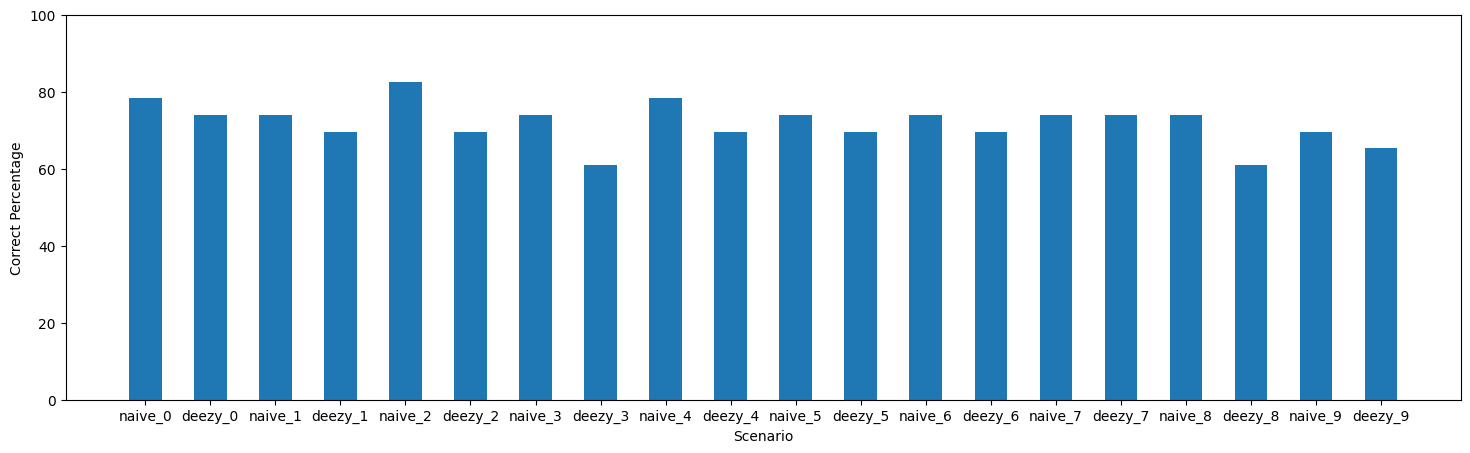

In [97]:
diff_series = {}
original_words = df_comparisons.index
for series_name, series in df_comparisons.items():
  diff_words = series.index.difference(series.values)
  diff_series[series_name] = 100 * (1 - (len(diff_words) / len(series.values)))

#diff_series_df = pd.Series(diff_series)
plt.figure(figsize=(18, 5))  # width:20, height:3
plt.bar(diff_series.keys(), diff_series.values(), align='center', width=0.5)
plt.xlabel('Scenario')
plt.ylabel('Correct Percentage')
ax = plt.gca()
ax.set_ylim([0, 100])
plt.show()

In [94]:
diff_words_to_correct = list(set([format_word(x) for x in correct_sentence.split()]) - set([format_word(x) for x in some_sentance_with_error.split()]))
df_only_fixes = df_comparisons.filter(items=diff_words_to_correct, axis=0)
df_only_fixes

,naive_0,deezy_0,naive_1,deezy_1,naive_2,deezy_2,naive_3,deezy_3,naive_4,deezy_4,naive_5,deezy_5,naive_6,deezy_6,naive_7,deezy_7,naive_8,deezy_8,naive_9,deezy_9
watermelon,waterloo,trawled,waterloo,warned,weathermen,warned,warren,warned,watermelon,watermelon,waterman,warned,waterman,warned,warren,warned,waterloo,warned,warren,warned
jerusalem,jerusalem,jerusalem,jerusalem,veljanovski,jerusalem,jerisheh,jerusalem,veljanovski,jersey,describes,jerusalem,jerusalem,jerusalem,jerusalem,jerusalem,jerusalem,jerusalem,jerisheh,jerusalem,jerusalem
lemon,lemon,lemon,leone,globalforcewrestling.com,lemon,leone,leone,lemond,lemon,flexone,lemmon,lemond,leone,leone,leone,lemon,leone,ollie,leone,loeb
possible,possible,possible,possible,possible,possible,possible,possible,possible,possible,possible,possible,possible,possible,possible,possible,possible,possible,possible,possible,possible
london,london,london,london,london,london,london,london,london,london,london,london,london,london,london,london,london,london,london,london,london
please,please,settles,leases,stallion's,please,safeties,please,please,please,settlers,please,settles,please,peeresses,please,lipstick,please,settles,please,settles
banana,bananas,bandanna,banana,banana,banana,banana,annan,nana,banana,banana,banana,banana,banana,banana,lannan,anandamath,banana,nana,bandanna,bandanna
apple,appeal,papel,appeal,appealed,appeal,appice,appel,appel,appeal,appealed,appeal,appealed,appeal,appealed,appeal,appealed,appeal,apoel,appeal,padel
error,error,error,error,error,error,error,error,formed,error,error,error,error,error,error,error,error,error,error,error,error


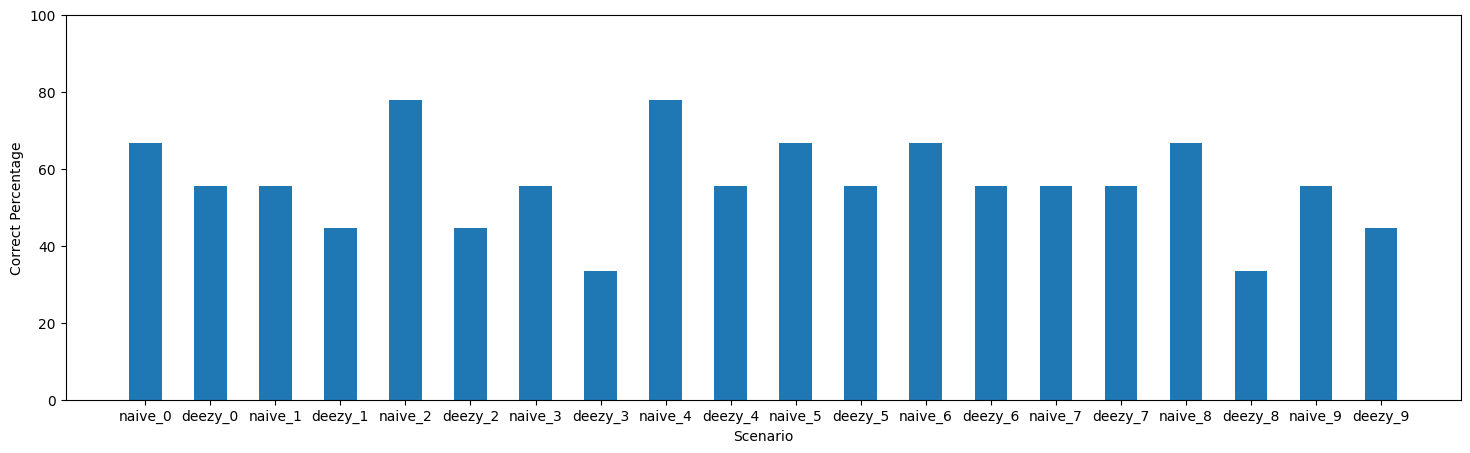

In [98]:
diff_series = {}
original_words = df_only_fixes.index
for series_name, series in df_only_fixes.items():
  diff_words = series.index.difference(series.values)
  diff_series[series_name] = 100 * (1 - (len(diff_words) / len(series.values)))

#diff_series_df = pd.Series(diff_series)
plt.figure(figsize=(18, 5))  # width:20, height:3
plt.bar(diff_series.keys(), diff_series.values(), align='center', width=0.5)
plt.xlabel('Scenario')
plt.ylabel('Correct Percentage')
ax = plt.gca()
ax.set_ylim([0, 100])
plt.show()

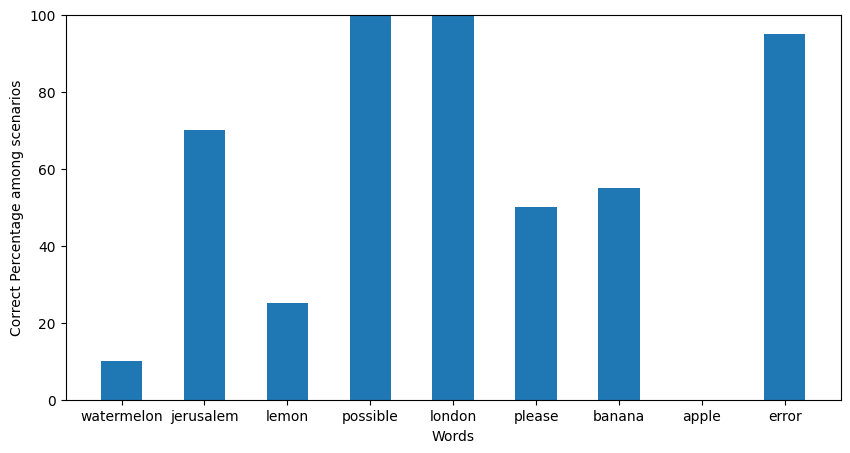

In [104]:
diff_series_by_word = {}
original_words = df_only_fixes.index
for index_name, row in df_only_fixes.iterrows():
  diff_words = [x for x in row if x != index_name]
  diff_series_by_word[index_name] = 100 * (1 - (len(diff_words) / len(row)))

#diff_series_df = pd.Series(diff_series)
plt.figure(figsize=(10, 5))  # width:20, height:3
plt.bar(diff_series_by_word.keys(), diff_series_by_word.values(), align='center', width=0.5)
plt.xlabel('Words')
plt.ylabel('Correct Percentage among scenarios')
ax = plt.gca()
ax.set_ylim([0, 100])
plt.show()

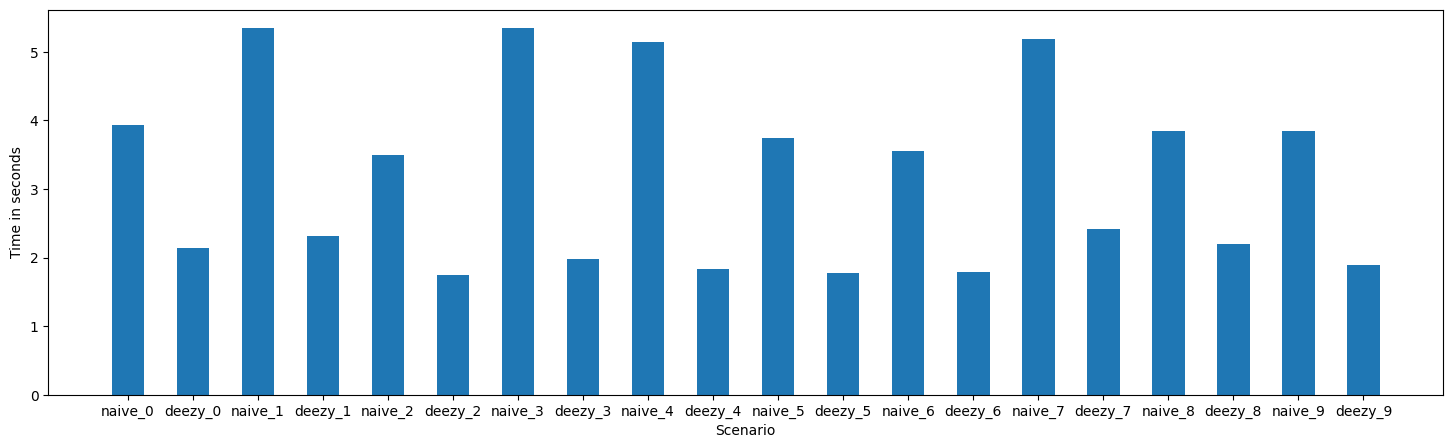

In [106]:
set_times = {}
for index, words_list in enumerate(words_set):
  set_times[f"naive_{index}"] = words_list['time_naive_sec']
  set_times[f"deezy_{index}"] = words_list['time_deezy_sec']

#diff_series_df = pd.Series(diff_series)
plt.figure(figsize=(18, 5))  # width:20, height:3
plt.bar(set_times.keys(), set_times.values(), align='center', width=0.5)
plt.xlabel('Scenario')
plt.ylabel('Time in seconds')
ax = plt.gca()
plt.show()